In [35]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import random
import math
import scipy.linalg as la
from numpy.linalg import inv
import time

In [36]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [37]:
np.set_printoptions(suppress=True)

In [38]:
# The function generates matrix sizes for a range of numbers
def matrixSizesGenerator(start, stop, step):
    matrixSizes = list()
    for num in range(start, stop, step):
        matrixSizes.append(num)
    return matrixSizes

In [39]:
# The function takes tuple as size of the matrix (m*n) and generates zero matrix
def zeroMatrixCreator(shape): 
    zeroMatrix = np.zeros(shape, dtype=np.int64, order='C')
    return zeroMatrix

In [40]:
#The function takes zero matrix as input, and populates it with real random generated numbers in pre-defined range
def matrixWithValuesInRange(matrix, minValue, maxValue): 
    m, n = matrix.shape
    for i in range(m):
        for j in range(n):
            matrix[i,j] = random.randrange(minValue, maxValue)
    return matrix.astype(np.int64)
    

In [41]:
#The function takes random generated matrix and produces 
def positiveSemiDefinite(matrix):
    matrixPSD = np.dot(matrix,matrix.transpose()).astype(np.int64)
    return matrixPSD
    

In [42]:
#The function implements Cholesky decomposition: A = R*R (R transpose times R). 
def choleskyM(A):
    n = len(A)
    R = [[0] * n for i in range(n)]
    for i in range(n):
        for j in range(n):
            s = sum([R[k][i] * R[k][j] for k in range(i)])
            if i == j:
                #print(s)
                R[i][i] = math.sqrt(A[i][i] - s)
            if i < j:
                R[i][j] = 1/R[i][i] *(A[i][j] - s)
    return np.asarray(R).astype(np.float64)

In [43]:
#The function produces diagonal matrix S. The function takes R matrix as input
def diagonalMatrixS(matrixR):
    m, n = matrixR.shape
    matrixS = zeroMatrixCreator((m, n)).astype(np.float64)
    for i in range(m):
        for j in range(n):
            if i == j:
                matrixS[i,j] = (1.0/matrixR[i,j])
    return matrixS.astype(np.float64)

In [44]:
#The function solves the system of linear equations RX = S. 
#The function takes upper-triangular matrix and diagonal matrix as input
def backwardSubstitution(matrixR, matrixS): #rename matrix
    m, n = matrixS.shape
    xMatrix = zeroMatrixCreator((m, n)).astype(np.float64)
    for i in range(m):
        #print(i)
        c = matrixS[:,i].astype(np.float64)
        #print("column:", i, c)
        x = la.solve_triangular(matrixR, c)
        #x = np.linalg.solve(matrixR,c).astype(np.float64)
        #print("solutions", i, x)
        #print(np.allclose(np.dot(matrixR, x), c))
        xMatrix[i] = x
    xMatrix = np.transpose(xMatrix)
    return xMatrix

In [45]:
#The function solves the system of linear equations RX = S. 
#The function takes lower-triangular matrix and identity matrix as input
def forwardSubstitution(matrixR, matrixS): #rename matrix
    m, n = matrixS.shape
    xMatrix = zeroMatrixCreator((m, n)).astype(np.float64)
    for i in range(m):
        #print(i)
        c = matrixS[:,i].astype(np.float64)
        #print("column:", i, c)
        x = la.solve_triangular(matrixR, c, lower=True)
        #x = np.linalg.solve(matrixR,c).astype(np.float64)
        #print("solutions", i, x)
        #print(np.allclose(np.dot(matrixR, x), c))
        xMatrix[i] = x
    xMatrix = np.transpose(xMatrix)
    return xMatrix

In [46]:
#The function enriches the entries below the diagonal with values of above the diagonal of upper-triangular matrix.

def enrichRMatrix(matrix):
    matrixE = np.copy(matrix)
    m, n = matrixE.shape
    for i in range(m):
        for j in range(n):
            if i==j:
                #print(matrixE[i][j])
                for ij in range(j+1, n):
                    #print("New", matrixE[i][ij])
                    matrixE[ij][i] = matrixE[i][ij]
                    #print(matrixE)
    return matrixE

In [47]:
# The function generates set of semi-positive symetric matrix for a given range of numbers
def matricesGeneratorSMP(startSize, endSize, step, mrange):
    sizes = matrixSizesGenerator(startSize, endSize, step)
    matrixBatch = []
    for i in sizes:
        matrix = zeroMatrixCreator((i, i))
        matrix = matrixWithValuesInRange(matrix, 1, mrange)
        matrix = positiveSemiDefinite(matrix)
        #print(matrix)
        matrixBatch.append(matrix)
    return matrixBatch

In [48]:
#The function executes the Proposed method
def executorScenario1(batch, numOfIterations):
    print("Executor starting time", time.ctime(int(time.time())))
    output = []
    procTime = dict()
    for matrix in batch:
        m, n = matrix.shape
        pTimeL = []
        for a in range(numOfIterations):
            print("Size: ", m, "-", time.ctime(int(time.time())))
            start = time.clock()
            R = choleskyM(matrix)
            S = diagonalMatrixS(R)
            #print(S)
            X = backwardSubstitution(R,S)
            #print(X)
            XE = enrichRMatrix(X)
            #print(XE)
            pTime = time.clock() - start
            pTimeL.append(pTime)
        procTime[m] = (sum(pTimeL)/len(pTimeL))
        output.append(XE)
    print("Executor finishing time", time.ctime(int(time.time())))  
    return (procTime, output)

In [49]:
#The function executes the Existing method
def executorScenario2(batch, numOfIterations):
    print("Executor starting time", time.ctime(int(time.time())))
    output = []
    procTime = dict()
    for matrix in batch:
        m, n = matrix.shape
        pTimeL = []
        for a in range(numOfIterations):
            print("Size: ", m, "-", time.ctime(int(time.time())))
            start = time.clock()
            R = choleskyM(matrix)
            I = np.eye(m)
            #print(I)
            B = forwardSubstitution(R.T,I)
            #print(B)
            X = backwardSubstitution(R,B)
            #print(X)
            pTime = time.clock() - start
            pTimeL.append(pTime)
        procTime[m] = (sum(pTimeL)/len(pTimeL))
        output.append(X)
    print("Executor finishing time", time.ctime(int(time.time())))    
    return (procTime, output)

In [19]:
batch = matricesGeneratorSMP(10, 10000, 1000, 10)

[[348 185 206 251 203 309 283 312 203 265]
 [185 145 132 134 119 182 151 205 145 156]
 [206 132 196 160 139 229 199 221 169 161]
 [251 134 160 291 166 313 298 243 189 226]
 [203 119 139 166 187 223 202 178 169 138]
 [309 182 229 313 223 401 364 319 265 277]
 [283 151 199 298 202 364 390 264 232 257]
 [312 205 221 243 178 319 264 396 242 308]
 [203 145 169 189 169 265 232 242 277 162]
 [265 156 161 226 138 277 257 308 162 296]]
[[31920 25121 25036 ..., 24756 25050 25436]
 [25121 33273 25777 ..., 25704 25800 26753]
 [25036 25777 32057 ..., 25538 26319 25957]
 ..., 
 [24756 25704 25538 ..., 31740 26005 25927]
 [25050 25800 26319 ..., 26005 32995 26253]
 [25436 26753 25957 ..., 25927 26253 33377]]
[[64748 51048 50409 ..., 50510 51087 51132]
 [51048 64804 49802 ..., 49957 50478 50643]
 [50409 49802 62913 ..., 49723 49845 50204]
 ..., 
 [50510 49957 49723 ..., 62370 49555 49384]
 [51087 50478 49845 ..., 49555 63658 49729]
 [51132 50643 50204 ..., 49384 49729 63328]]
[[95681 75190 75516 ..., 

In [23]:
batch2 = matricesGeneratorSMP(10, 1000, 50, 10)

[[312 249 279 234 239 188 160 225 250 238]
 [249 343 288 279 196 230 200 299 308 260]
 [279 288 418 265 222 225 215 250 334 242]
 [234 279 265 322 185 186 200 245 239 227]
 [239 196 222 185 213 126 132 195 213 181]
 [188 230 225 186 126 219 143 220 222 208]
 [160 200 215 200 132 143 162 181 210 151]
 [225 299 250 245 195 220 181 337 288 242]
 [250 308 334 239 213 222 210 288 348 226]
 [238 260 242 227 181 208 151 242 226 291]]
[[2081 1543 1570 ..., 1848 1767 1645]
 [1543 1913 1529 ..., 1716 1556 1664]
 [1570 1529 2094 ..., 1786 1629 1792]
 ..., 
 [1848 1716 1786 ..., 2353 1880 1883]
 [1767 1556 1629 ..., 1880 2064 1720]
 [1645 1664 1792 ..., 1883 1720 2133]]
[[3499 2920 2433 ..., 2610 2567 2872]
 [2920 3677 2695 ..., 2752 2681 3051]
 [2433 2695 2957 ..., 2302 2289 2516]
 ..., 
 [2610 2752 2302 ..., 3355 2534 2682]
 [2567 2681 2289 ..., 2534 3058 2573]
 [2872 3051 2516 ..., 2682 2573 3559]]
[[5354 4022 4006 ..., 4429 4205 4285]
 [4022 4817 3743 ..., 4131 4105 3902]
 [4006 3743 4716 ...,

In [24]:
scenario1 = executorScenario1(batch2, 1)

In [25]:
procTimeSc1, batchOSc1 = scenario1

In [26]:
procTimeSc1

{10: 0.002547000000049593,
 60: 0.05558100000052946,
 110: 0.24546399999962887,
 160: 0.691262999999708,
 210: 1.5238980000003721,
 260: 3.1744089999992866,
 310: 4.769304000000375,
 360: 8.077478000000156,
 410: 12.103360000000066,
 460: 17.683375999999953,
 510: 22.756054000000404,
 560: 31.29052799999954,
 610: 41.80482800000027,
 660: 49.663110999999844,
 710: 63.672537999999804,
 760: 74.27662799999962,
 810: 97.47289199999977,
 860: 114.9629700000005,
 910: 124.98208599999998,
 960: 145.57753700000012}

In [29]:
scenario2 = executorScenario2(batch2, 1)

In [30]:
procTimeSc2, batchOSc2 = scenario2

In [31]:
processingTime = {"Scenario 1": procTimeSc1, "Scenario 2": procTimeSc2, }

In [32]:
processingTimeDF = df(processingTime)

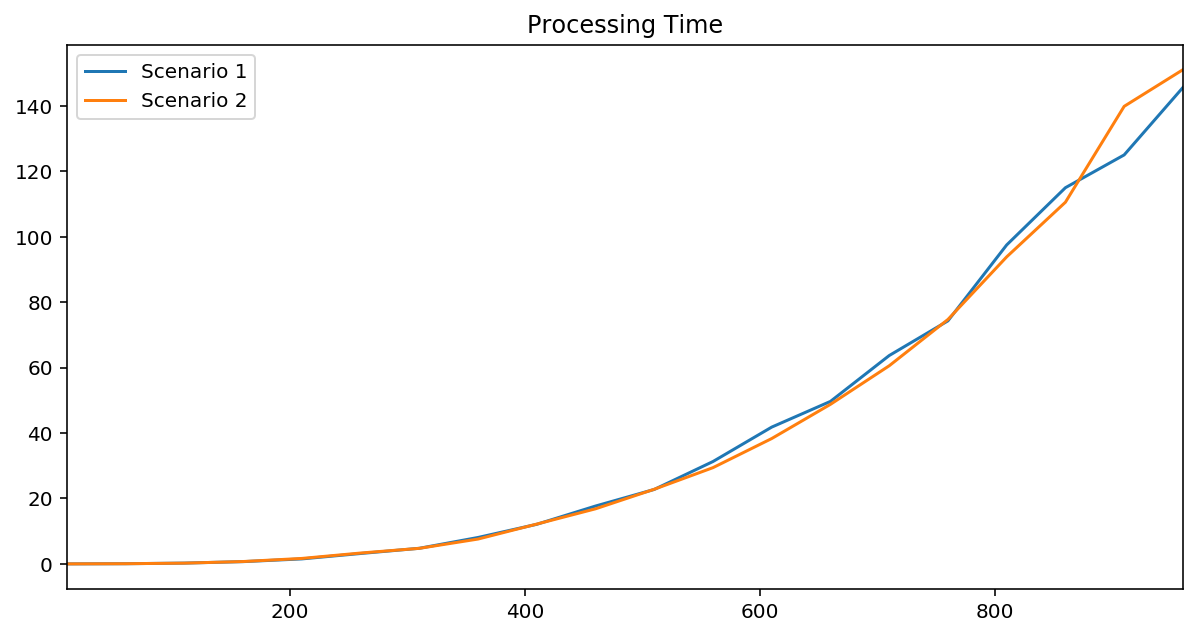

In [43]:
processingTimeDF.plot(figsize = (10,5), title="Processing Time")

In [33]:
processingTimeDF

,Scenario 1,Scenario 2
10,0.002547,0.004077
60,0.055581,0.056231
110,0.245464,0.231764
160,0.691263,0.722228
210,1.523898,1.670570
260,3.174409,3.320431
310,4.769304,4.754379
360,8.077478,7.595274
410,12.103360,12.167316
460,17.683376,16.835988


In [40]:
batch3 = matricesGeneratorSMP(100, 2000, 300, 10)

[[3374 2529 2599 ..., 2491 2906 2678]
 [2529 2931 2255 ..., 2371 2630 2417]
 [2599 2255 3154 ..., 2380 2719 2379]
 ..., 
 [2491 2371 2380 ..., 3033 2760 2502]
 [2906 2630 2719 ..., 2760 3477 2646]
 [2678 2417 2379 ..., 2502 2646 3065]]
[[12286  9467  9497 ...,  9584  9877  9794]
 [ 9467 11591  9372 ...,  9287  9517  9368]
 [ 9497  9372 12246 ...,  9724 10149  9583]
 ..., 
 [ 9584  9287  9724 ..., 12232  9911  9229]
 [ 9877  9517 10149 ...,  9911 13012  9792]
 [ 9794  9368  9583 ...,  9229  9792 12147]]
[[20942 17472 16469 ..., 17177 17295 16647]
 [17472 23496 18414 ..., 17954 18619 17726]
 [16469 18414 22426 ..., 17240 18042 17343]
 ..., 
 [17177 17954 17240 ..., 22138 17998 16986]
 [17295 18619 18042 ..., 17998 22866 17705]
 [16647 17726 17343 ..., 16986 17705 21652]]
[[32448 25522 24748 ..., 26166 24985 25331]
 [25522 32029 24291 ..., 25615 24950 25237]
 [24748 24291 30325 ..., 24959 24034 24484]
 ..., 
 [26166 25615 24959 ..., 32823 25416 25813]
 [24985 24950 24034 ..., 25416 31154 

In [60]:
scenario3 = executorScenario1(batch3, 1)

Executor starting time Thu Dec 14 00:19:08 2017
Size:  100 - Thu Dec 14 00:19:08 2017
Size:  400 - Thu Dec 14 00:19:08 2017
Size:  700 - Thu Dec 14 00:19:18 2017
Size:  1000 - Thu Dec 14 00:20:22 2017
Size:  1300 - Thu Dec 14 00:23:34 2017
Size:  1600 - Thu Dec 14 00:30:20 2017
Size:  1900 - Thu Dec 14 00:44:03 2017
Executor ending time Thu Dec 14 01:05:11 2017


In [61]:
procTimeSc3, batchOSc3 = scenario3

In [62]:
procTimeSc3

{100: 0.18808899999930873,
 400: 10.401168000000325,
 700: 62.31818200000089,
 1000: 188.42526399999952,
 1300: 399.63356700000077,
 1600: 797.0748799999983,
 1900: 1257.8015879999984}

In [64]:
scenario4 = executorScenario2(batch3, 1)

Executor starting time Thu Dec 14 10:07:30 2017
Size:  100 - Thu Dec 14 10:07:30 2017
Size:  400 - Thu Dec 14 10:07:30 2017
Size:  700 - Thu Dec 14 10:07:40 2017
Size:  1000 - Thu Dec 14 10:08:54 2017
Size:  1300 - Thu Dec 14 10:12:12 2017
Size:  1600 - Thu Dec 14 10:19:40 2017
Size:  1900 - Thu Dec 14 10:32:35 2017
Executor finishing time Thu Dec 14 10:56:23 2017


In [65]:
procTimeSc4, batchOSc4 = scenario4

In [66]:
procTimeSc4

{100: 0.2548220000026049,
 400: 12.256473000001279,
 700: 65.39476500000092,
 1000: 195.87558300000092,
 1300: 436.0163390000016,
 1600: 765.2371200000016,
 1900: 1390.4659900000006}

In [67]:
processingTime2 = {"Scenario 1": procTimeSc3, "Scenario 2": procTimeSc4, }

In [68]:
processingTimeDF2 = df(processingTime2)

In [70]:
processingTimeDF2

,Scenario 1,Scenario 2
100,0.188089,0.254822
400,10.401168,12.256473
700,62.318182,65.394765
1000,188.425264,195.875583
1300,399.633567,436.016339
1600,797.074880,765.237120
1900,1257.801588,1390.465990


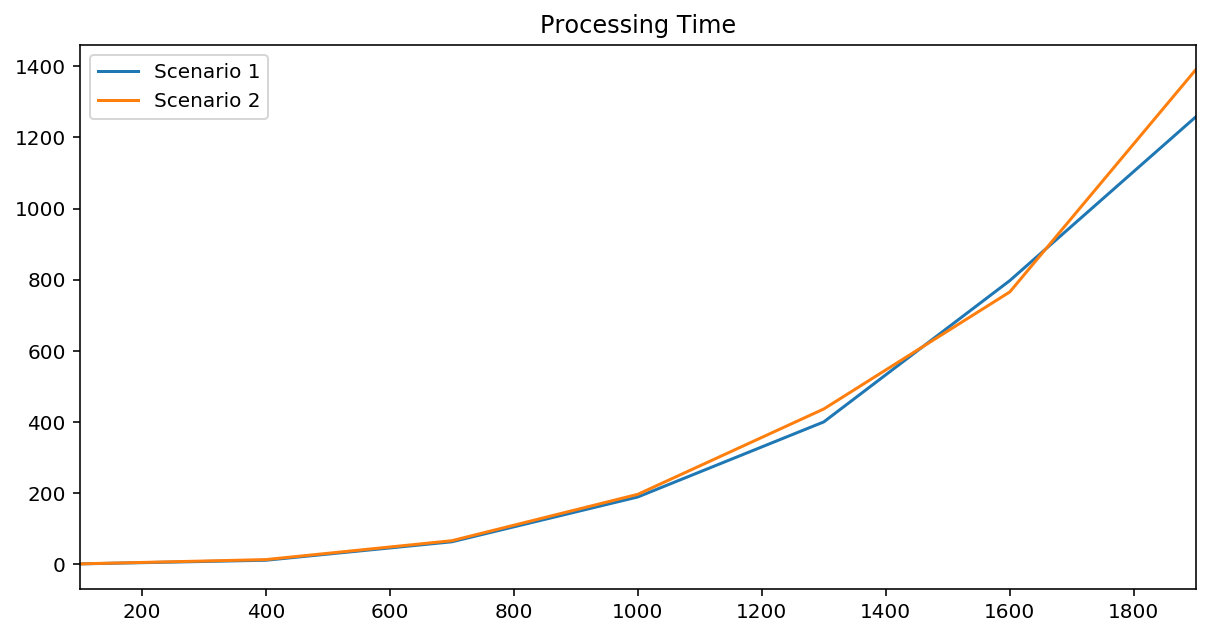

In [69]:
processingTimeDF2.plot(figsize = (10,5), title="Processing Time")

In [ ]:
# The function of forward substitution was built but was not incorporated into existing code due to the lack of time
def forward_substitution(L, b):
    n = len(L)
    y = [[0]  for i in range(n)]
    for i in range(n):
        y[i] = b[i]
        for j in range(i):
            y[i] -= L[i][j] * y[i]
    return y

In [ ]:
# The function of back substitution was built but was not incorporated into existing code due to the lack of time
def back_substitution(U, y):
    n = len(U)
    x = [[0]  for i in range(n)]
    for i in range(n,0,-1):
        x[i] = y[i]
        for j in range(i + 1, n):
            x[i] = x[i] - U[i][j]
        x[i] = x[i]/U[i][i]
    return x